In [18]:
import pandas as pd 
import gc
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import time

In [2]:
with pd.HDFStore('../input/feat/feat_109903890_149903890.h5') as store:
    print(store.keys())
    train_df = store['train_df']
    val_df = store['valid_df']
    test_df = store['test_df']

['/test_df', '/train_df', '/valid_df']


In [3]:
print('shape of train:{}'.format(train_df.shape))
print('shape of val  :{}'.format(val_df.shape))
print('shape of test :{}'.format(test_df.shape))

shape of train:(37500000, 30)
shape of val  :(2500000, 30)
shape of test :(18790469, 30)


In [4]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.2,
        #'is_unbalance': 'true',  #because training data is unbalance (replaced with scale_pos_weight)
        'num_leaves': 31,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    print("\nModel Report")
    print("bst1.best_iteration: ", bst1.best_iteration)
    print(metrics+":", evals_results['valid'][metrics][bst1.best_iteration-1])

    return (bst1,bst1.best_iteration)

In [19]:
print("Training...")
start_time = time.time()

params = {
    'learning_rate': 0.20,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200 # because training data is extremely unbalanced 
}

target = 'is_attributed'
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']

predictors = list(val_df.columns)
remove_col = ['click_id','click_time','epochtime','is_attributed']
predictors = [e for e in predictors if e not in remove_col]


(bst,best_iteration) = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1000, 
                        categorical_features=categorical)

Training...
preparing validation datasets


C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.971151	valid's auc: 0.966875
[20]	train's auc: 0.977322	valid's auc: 0.97197
[30]	train's auc: 0.980198	valid's auc: 0.974396
[40]	train's auc: 0.981631	valid's auc: 0.975144
[50]	train's auc: 0.982539	valid's auc: 0.97584
[60]	train's auc: 0.983127	valid's auc: 0.97595
[70]	train's auc: 0.983592	valid's auc: 0.97622
[80]	train's auc: 0.983977	valid's auc: 0.976461
[90]	train's auc: 0.984266	valid's auc: 0.976653
[100]	train's auc: 0.98455	valid's auc: 0.976673
[110]	train's auc: 0.984766	valid's auc: 0.976814
[120]	train's auc: 0.985042	valid's auc: 0.976757
[130]	train's auc: 0.985178	valid's auc: 0.976858
[140]	train's auc: 0.985347	valid's auc: 0.976848
[150]	train's auc: 0.985461	valid's auc: 0.976916
[160]	train's auc: 0.985585	valid's auc: 0.976977
[170]	train's auc: 0.985702	valid's auc: 0.976994
[180]	train's auc: 0.985782	valid's auc: 0.977043
[190]	train's auc: 0.985888	valid's auc: 0.976986
Ea

# Sub 
- baseline 

Plot feature importances...


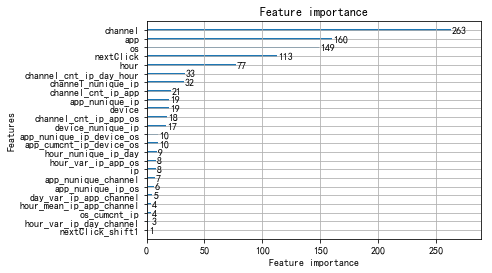

In [20]:
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=100)

In [23]:
bst.save_model('../output/model/lgb_base_val_97705.txt')

In [25]:
sub = pd.DataFrame()
sub['click_id'] = test_df['click_id'].astype(int)

print("Predicting...")
sub['is_attributed'] = bst.predict(test_df[predictors],num_iteration=best_iteration)
    

Predicting...


In [26]:
sub.head()

,click_id,is_attributed
0,0,0.143483
1,1,0.029520
2,2,0.002316
3,3,0.054001
4,4,0.009399


In [27]:
print('writing...')
fileno = 1
sub.to_csv('../output/sub_it{}.csv.gz'.format(fileno),index=False,compression='gzip')

writing


In [28]:
sub.head(10)

,click_id,is_attributed
0,0,0.143483
1,1,0.029520
2,2,0.002316
3,3,0.054001
4,4,0.009399
5,5,0.005655
6,6,0.016355
7,7,0.081986
8,9,0.083931
9,8,0.011522


# Hyperopt 
parameter tuning 

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK,Trials
import numpy as np 


In [81]:
print("preparing validation datasets...")
dtrain = train_df 
dvalid = val_df

xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical,
                      free_raw_data=False
                      )
xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical,
                      free_raw_data=False
                      )

preparing validation datasets...


In [82]:
def lgbm_objective(params):
    t1 = time.time()
    evals_results = {}
    reg = lgb.train(params,
                    train_set = xgtrain,                    
                    valid_sets=[xgtrain, xgvalid], 
                    valid_names=['train','valid'],
                    evals_result = evals_results,
                    early_stopping_rounds = 30 ,                    
                    verbose_eval = 10) ## 
    auc = evals_results['valid']['auc'][reg.best_iteration-1]
    t2 = time.time()    
    sec = int((t2-t1) % 60)
    mins = int((t2-t1) // 60)
    print('training time : {} min {} sec ...'.format(mins,sec))
    print('params:{}'.format(params))
    
    print('auc:{:.5f}'.format(reg.best_score['valid']['auc']))
    print('best iteration:{}'.format(reg.best_iteration))
    
    print('-------------'*5)
    
    return {'loss':reg.best_score['valid']['auc'], 'status': STATUS_OK }

In [ ]:
# params = {
#     'learning_rate': 0.20,
#     #'is_unbalance': 'true', # replaced with scale_pos_weight argument
#     'num_leaves': 7,  # 2^max_depth - 1
#     'max_depth': 3,  # -1 means no limit
#     'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
#     'max_bin': 100,  # Number of bucketed bin for feature values
#     'subsample': 0.7,  # Subsample ratio of the training instance.
#     'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
#     'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
#     'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
#     'scale_pos_weight':200 # because training data is extremely unbalanced 
# }

In [83]:
lgbm_space = {
#     'boosting_type'   : hp.choice('boosting_type',['gbdt', 'dart']), ## gbdt 
    'boosting_type'   : 'gbdt',  
#     'max_depth'       : hp.choice("max_depth", np.arange(20, 500, dtype=int)),
    'learning_rate'   : hp.uniform('learning_rate', 0.1, 0.5),
    'num_boost_round' : 1000, ## num_iterations
    'num_leaves'      : hp.choice('num_leaves', np.arange(8,129,2,dtype=int)), ## no limit     
    'min_data_in_leaf': 100, ## prevent overfit
    'max_bin'         : hp.choice('max_bin', np.arange(10,100,10,dtype=int)),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0), ## colsample_bytree
    'bagging_fraction': hp.uniform ('bagging_fraction', 0.7, 1), ## subsample, can be used to speed up training/ deal with overfitting
    'reg_lambda'      : hp.uniform('reg_lambda',0,1),
    'gamma'           : hp.uniform('gamma', 0.1,0.5),
    'metric'          : 'auc',
    'min_child_weight': hp.uniform('min_child_weight', 0, 0.1),    
    'scale_pos_weight': hp.uniform('scale_pos_weight',100,300)    
}

In [ ]:
trials = Trials()
best =fmin(fn = lgbm_objective,
           space = lgbm_space,
           algo = tpe.suggest,
           trials = trials,
           max_evals = 10
           )

C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Program Files\Anaconda3\envs\py36\lib\site-packages\lightgbm\basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
